# Creating the final model from scratch, based on hyperparameters testing

In [13]:
from pathlib import Path
import sys


here = Path.cwd()
candidates = [here] + list(here.parents)
for p in candidates:
    if (p / "Code").is_dir():
        sys.path.insert(0, str(p))
        break
else:
    raise RuntimeError("Couldn't find a 'Code' folder in this project.")


import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd


from Code.PINN import create_network_model, u, compute_loss, g_trial_tf, make_train_step, compute_MSE
from Code.functions import euler, analytical_u

In [21]:
best_layers = [150]
best_activation = 'tanh'
best_learning_rate = 0.01
epochs = 10000
T_final = 0.5


model = create_network_model(
    layers=best_layers,
    activation=best_activation
)

optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
train_step = make_train_step(model, optimizer, compute_loss)

# Training loop

N_points = 2000
x_samples = np.random.uniform(0.0, 1.0, N_points)
t_samples = np.random.uniform(0.0, T_final, N_points)
X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)

# TRAINING LOOP (IMPORTANT!)
for epoch in range(epochs):
    loss = train_step(X_train)
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Residual Loss = {loss.numpy():.3e}")

# Compute final MSE vs analytical solution
mse = compute_MSE(model, T_final=T_final)
print(f"\nFinal residual loss: {loss.numpy():.3e}")
print(f"MSE vs analytical:     {mse:.3e}")


mse = compute_MSE(model, T_final=0.5)
print("Total MSE over domain:", mse)


Epoch 500/10000, Residual Loss = 2.117e-01
Epoch 1000/10000, Residual Loss = 2.069e-02
Epoch 1500/10000, Residual Loss = 1.011e-02
Epoch 2000/10000, Residual Loss = 6.375e-03
Epoch 2500/10000, Residual Loss = 4.106e-03
Epoch 3000/10000, Residual Loss = 2.634e-02
Epoch 3500/10000, Residual Loss = 2.187e-03
Epoch 4000/10000, Residual Loss = 1.848e-03
Epoch 4500/10000, Residual Loss = 1.628e-03
Epoch 5000/10000, Residual Loss = 1.484e-03
Epoch 5500/10000, Residual Loss = 1.368e-03
Epoch 6000/10000, Residual Loss = 1.272e-03
Epoch 6500/10000, Residual Loss = 1.182e-03
Epoch 7000/10000, Residual Loss = 1.089e-03
Epoch 7500/10000, Residual Loss = 9.824e-04
Epoch 8000/10000, Residual Loss = 8.290e-04
Epoch 8500/10000, Residual Loss = 6.495e-04
Epoch 9000/10000, Residual Loss = 5.038e-04
Epoch 9500/10000, Residual Loss = 3.808e-04
Epoch 10000/10000, Residual Loss = 3.013e-04

Final residual loss: 3.013e-04
MSE vs analytical:     1.433e-08
Total MSE over domain: 1.4331023984299925e-08


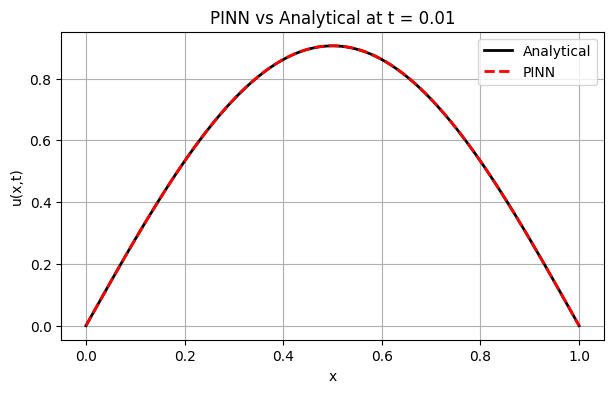

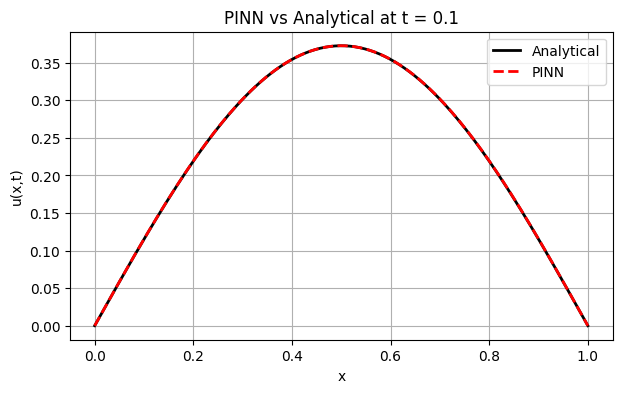

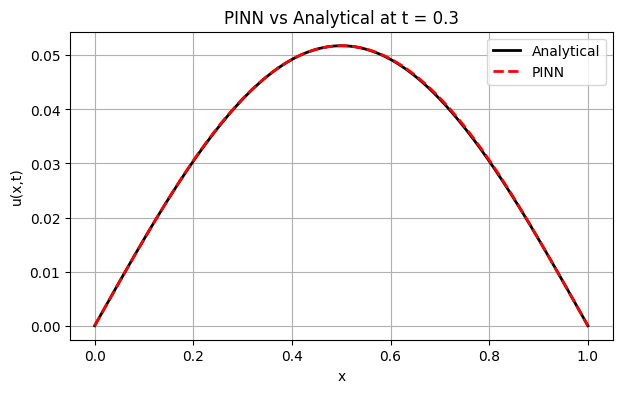

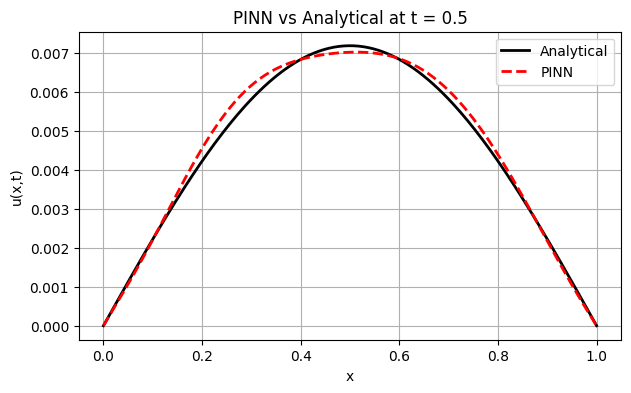

In [22]:


def pinn_solution_1d(model, x, t):
    X = np.stack([x, np.full_like(x, t)], axis=1).astype(np.float32)
    N_out = model(X)
    g_val = g_trial_tf(tf.constant(X, dtype=tf.float32), model, N_out)
    return g_val.numpy().flatten()

# Time slices for comparison
t_vals = [0.01, 0.10, 0.30, 0.50]
x = np.linspace(0, 1, 200)

for t_val in t_vals:
    u_pinn  = pinn_solution_1d(model, x, t_val)
    u_exact = analytical_u(x, t_val)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_exact, 'k-', lw=2, label='Analytical')
    plt.plot(x, u_pinn, 'r--', lw=2, label='PINN')
    plt.title(f"PINN vs Analytical at t = {t_val}")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.legend()
    plt.grid(True)
    plt.show()


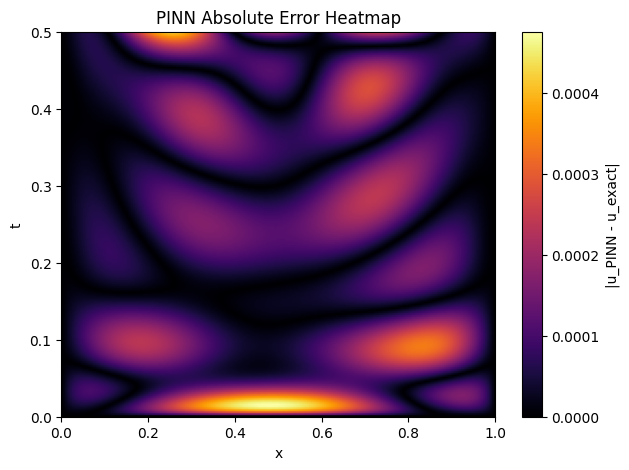

In [23]:
nx, nt = 200, 200
x = np.linspace(0, 1, nx)
t = np.linspace(0, 0.5, nt)
X, T = np.meshgrid(x, t)

X_flat = X.reshape(-1,1).astype(np.float32)
T_flat = T.reshape(-1,1).astype(np.float32)
X_input = np.hstack([X_flat, T_flat])

X_tf = tf.constant(X_input, dtype=tf.float32)
N_out = model(X_tf)
u_pinn = g_trial_tf(X_tf, model, N_out).numpy().reshape(nt, nx)

u_exact = analytical_u(X, T)

error = np.abs(u_pinn - u_exact)

plt.figure(figsize=(7,5))
plt.imshow(error, extent=[0,1,0,0.5], origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label="|u_PINN - u_exact|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Absolute Error Heatmap")
plt.show()


In [24]:
def plot_all(x, t_grid, U, t_target, NN_model, title, N_output=1):
    n_idx = np.argmin(np.abs(t_grid - t_target))
    u_euler = U[n_idx]
    u_exact = analytical_u(x, t_target)
    u_pinn  = pinn_solution(NN_model, x, t_target, N_output)

    plt.figure(figsize=(7,4))
    plt.plot(x, u_exact, 'k-', lw=2, label="Analytical")
    plt.plot(x, u_euler, 'o', label="Euler FD")
    plt.plot(x, u_pinn, '-', label="PINN")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


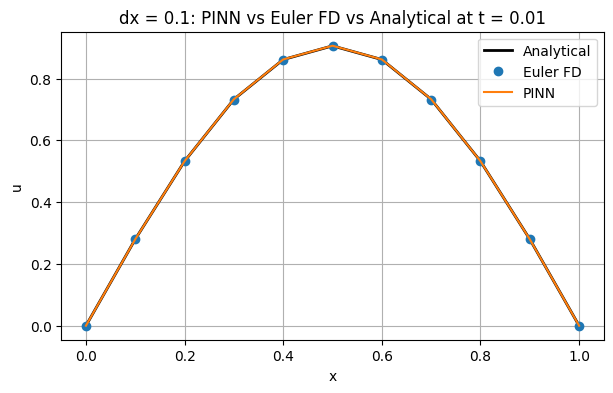

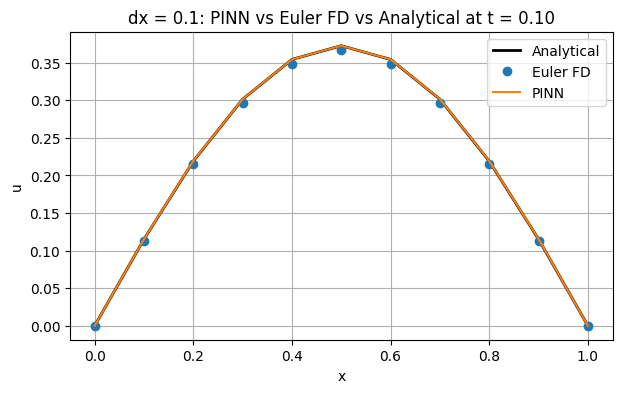

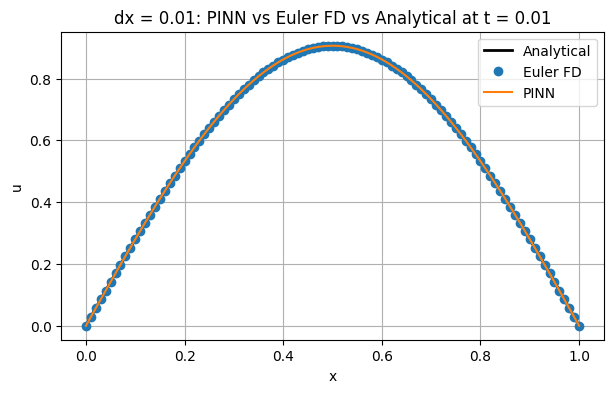

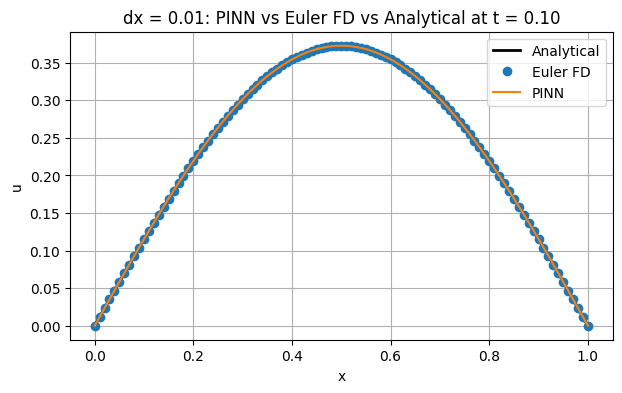

In [25]:
def pinn_solution(model, x, t_value, N_output=1):
    X_eval = np.stack([x, np.full_like(x, t_value)], axis=1).astype(np.float32)
    g_val = g_trial_tf(X_eval, model, N_output)
    return g_val.numpy().flatten()


dx1 = 0.1
dt1 = 0.005        # stability limit: dt = dx^2 / 2 = 0.005
x1, t1, U1 = euler(dx1, dt1, T=0.2)

# Case 2: dx = 0.01
dx2 = 0.01
dt2 = 0.00005        # stability limit: dt = dx^2 / 2 = 5e-5
x2, t2, U2 = euler(dx2, dt2, T=0.2)

t1_val, t2_val = 0.01, 0.10   # or any times you like

plot_all(x1, t1, U1, t1_val, model,
         "dx = 0.1: PINN vs Euler FD vs Analytical at t = 0.01")
plot_all(x1, t1, U1, t2_val, model,
         "dx = 0.1: PINN vs Euler FD vs Analytical at t = 0.10")

plot_all(x2, t2, U2, t1_val, model,
         "dx = 0.01: PINN vs Euler FD vs Analytical at t = 0.01")
plot_all(x2, t2, U2, t2_val, model,
         "dx = 0.01: PINN vs Euler FD vs Analytical at t = 0.10")
